Import Library

In [44]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN

# (opsional untuk slider)
import ipywidgets as widgets
from IPython.display import display

# ----------------------------
# KONFIGURASI PATH DASAR
# ----------------------------
# Folder input: 3 subjek (Afi, Miftah, Kinan)
INPUT_ROOT = r"E:\1.Clustering_TA\dataset"

# Folder output:
OUTPUT_ROOT = r"E:\1.Clustering_TA\output_clustering"

FOLDER_CLUSTERED = os.path.join(OUTPUT_ROOT, "01_clustered_point_cloud")
FOLDER_TORSO = os.path.join(OUTPUT_ROOT, "02_torso_per_frame")

# Buat folder jika belum ada
os.makedirs(FOLDER_CLUSTERED, exist_ok=True)
os.makedirs(FOLDER_TORSO, exist_ok=True)

print("Input root :", INPUT_ROOT)
print("Output clustered :", FOLDER_CLUSTERED)
print("Output torso :", FOLDER_TORSO)


Input root : E:\1.Clustering_TA\dataset
Output clustered : E:\1.Clustering_TA\output_clustering\01_clustered_point_cloud
Output torso : E:\1.Clustering_TA\output_clustering\02_torso_per_frame


Scan Semua File CSV per Subjek

In [45]:
def list_subject_files(input_root):
    """
    Mengembalikan dict:
    {
        'Afi':    [path_csv1, path_csv2, ...],
        'Miftah': [...],
        'Kinan':  [...]
    }
    """
    subjects = ["Afi", "Miftah", "Kinan"]
    files_per_subject = {}

    for subj in subjects:
        subj_folder = os.path.join(input_root, subj)
        pattern = os.path.join(subj_folder, "*.csv")
        files = sorted(glob.glob(pattern))
        files_per_subject[subj] = files

    return files_per_subject

files_per_subject = list_subject_files(INPUT_ROOT)
files_per_subject


{'Afi': ['E:\\1.Clustering_TA\\dataset\\Afi\\Jalan1.csv',
  'E:\\1.Clustering_TA\\dataset\\Afi\\Jalan10.csv',
  'E:\\1.Clustering_TA\\dataset\\Afi\\Jalan11.csv',
  'E:\\1.Clustering_TA\\dataset\\Afi\\Jalan12.csv',
  'E:\\1.Clustering_TA\\dataset\\Afi\\Jalan13.csv',
  'E:\\1.Clustering_TA\\dataset\\Afi\\Jalan14.csv',
  'E:\\1.Clustering_TA\\dataset\\Afi\\Jalan15.csv',
  'E:\\1.Clustering_TA\\dataset\\Afi\\Jalan16.csv',
  'E:\\1.Clustering_TA\\dataset\\Afi\\Jalan17.csv',
  'E:\\1.Clustering_TA\\dataset\\Afi\\Jalan18.csv',
  'E:\\1.Clustering_TA\\dataset\\Afi\\Jalan19.csv',
  'E:\\1.Clustering_TA\\dataset\\Afi\\Jalan2.csv',
  'E:\\1.Clustering_TA\\dataset\\Afi\\Jalan20.csv',
  'E:\\1.Clustering_TA\\dataset\\Afi\\Jalan21.csv',
  'E:\\1.Clustering_TA\\dataset\\Afi\\Jalan22.csv',
  'E:\\1.Clustering_TA\\dataset\\Afi\\Jalan23.csv',
  'E:\\1.Clustering_TA\\dataset\\Afi\\Jalan24.csv',
  'E:\\1.Clustering_TA\\dataset\\Afi\\Jalan25.csv',
  'E:\\1.Clustering_TA\\dataset\\Afi\\Jalan26.csv',
  'E:\\

Fungsi DBSCAN per Frame & Helper Clustering

In [46]:
def run_dbscan_on_frame(df_frame, eps=0.25, min_samples=5):
    """
    Input: df_frame = subset DataFrame untuk 1 frame (kolom minimal: x, y, z)
    Output: array labels (panjang sama dengan df_frame)
    """
    X = df_frame[['x', 'y', 'z']].values

    # Jika titik terlalu sedikit, langsung semua dianggap noise
    if len(X) < min_samples:
        return np.full(len(X), -1, dtype=int)

    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X)
    return labels


def add_cluster_id_to_file(input_csv, output_csv, eps=0.25, min_samples=5):
    """
    Membaca 1 file CSV (point cloud mentah),
    menjalankan DBSCAN per frame,
    dan menyimpan ke CSV baru dengan kolom tambahan 'cluster_id'.
    """
    df = pd.read_csv(input_csv)

    if 'frame' not in df.columns:
        raise ValueError(f"File {input_csv} tidak punya kolom 'frame'")

    cluster_ids = np.empty(len(df), dtype=int)

    frames = sorted(df['frame'].unique())
    for fr in frames:
        mask = df['frame'] == fr
        df_f = df[mask]

        labels = run_dbscan_on_frame(df_f, eps=eps, min_samples=min_samples)
        cluster_ids[mask] = labels

    df['cluster_id'] = cluster_ids
    df.to_csv(output_csv, index=False)
    return df  # kembalikan df kalau mau dipakai lagi


Jalankan Clustering untuk Semua File (Folder 1)

In [47]:
# Hyperparameter DBSCAN (sementara fixed, nanti bisa dituning/HPO)
DBSCAN_EPS = 0.25
DBSCAN_MIN_SAMPLES = 5

def run_clustering_for_all_subjects(files_per_subject,
                                    folder_clustered,
                                    eps=DBSCAN_EPS,
                                    min_samples=DBSCAN_MIN_SAMPLES):
    """
    Loop semua subjek dan semua file,
    jalankan DBSCAN per frame,
    simpan hasilnya ke folder_clustered.
    """
    for subj, file_list in files_per_subject.items():
        print(f"\n=== Subjek: {subj} ===")
        for input_csv in file_list:
            base_name = os.path.basename(input_csv)
            name_no_ext = os.path.splitext(base_name)[0]

            output_csv = os.path.join(
                folder_clustered,
                f"{subj}_{name_no_ext}_clustered.csv"
            )

            print(f"  - Proses {base_name} → {os.path.basename(output_csv)}")
            add_cluster_id_to_file(input_csv, output_csv,
                                   eps=eps, min_samples=min_samples)

# Jalankan
run_clustering_for_all_subjects(files_per_subject, FOLDER_CLUSTERED)
print("\nSelesai clustering & simpan ke Folder 01.")



=== Subjek: Afi ===
  - Proses Jalan1.csv → Afi_Jalan1_clustered.csv
  - Proses Jalan10.csv → Afi_Jalan10_clustered.csv
  - Proses Jalan11.csv → Afi_Jalan11_clustered.csv
  - Proses Jalan12.csv → Afi_Jalan12_clustered.csv
  - Proses Jalan13.csv → Afi_Jalan13_clustered.csv
  - Proses Jalan14.csv → Afi_Jalan14_clustered.csv
  - Proses Jalan15.csv → Afi_Jalan15_clustered.csv
  - Proses Jalan16.csv → Afi_Jalan16_clustered.csv
  - Proses Jalan17.csv → Afi_Jalan17_clustered.csv
  - Proses Jalan18.csv → Afi_Jalan18_clustered.csv
  - Proses Jalan19.csv → Afi_Jalan19_clustered.csv
  - Proses Jalan2.csv → Afi_Jalan2_clustered.csv
  - Proses Jalan20.csv → Afi_Jalan20_clustered.csv
  - Proses Jalan21.csv → Afi_Jalan21_clustered.csv
  - Proses Jalan22.csv → Afi_Jalan22_clustered.csv
  - Proses Jalan23.csv → Afi_Jalan23_clustered.csv
  - Proses Jalan24.csv → Afi_Jalan24_clustered.csv
  - Proses Jalan25.csv → Afi_Jalan25_clustered.csv
  - Proses Jalan26.csv → Afi_Jalan26_clustered.csv
  - Proses Jal

Ekstrak Torso Per Frame (Folder 2)

In [48]:
import numpy as np
import pandas as pd

def extract_torso_per_frame(df_clustered,
                            z_tolerance=0.6,   # toleransi selisih z dari median (meter)
                            max_jump=0.6       # loncatan posisi maksimum antar frame (meter)
                           ):
    """
    Versi 'lebih pintar' untuk memilih torso per frame.
    
    Logika:
    1) Buang noise (cluster_id == -1)
    2) Hitung median z global (semua titik non-noise) → kira-kira tinggi torso.
    3) Untuk tiap frame:
        - hitung statistik per cluster: n_points, mean_x, mean_y, mean_z
        - pilih cluster yang:
            a) mean_z paling dekat dengan median z (dalam batas z_tolerance),
            b) dan jumlah titiknya terbesar.
        - jika tidak ada cluster dalam rentang z_tolerance → fallback ke aturan lama (cluster terbanyak).
        - jika jarak torso sekarang dengan torso sebelumnya > max_jump → pakai posisi sebelumnya (hold).
    4) Kembalikan DataFrame:
       frame, torso_cluster_id, torso_x, torso_y, torso_z,
       num_points_torso, is_held_from_prev
    """

    # -------------------------
    # 0. Siapkan z_median global
    # -------------------------
    df_valid_global = df_clustered[df_clustered['cluster_id'] != -1]
    if len(df_valid_global) == 0:
        raise ValueError("Tidak ada titik non-noise sama sekali di file ini.")

    z_median = df_valid_global['z'].median()
    print(f"z_median (perkiraan tinggi torso) ≈ {z_median:.3f} m")

    frames = sorted(df_clustered['frame'].unique())
    records = []

    # posisi torso sebelumnya (untuk kontinuitas)
    prev_torso_xyz = None
    prev_torso_cluster_id = None

    for fr in frames:
        df_f = df_clustered[df_clustered['frame'] == fr]
        df_valid = df_f[df_f['cluster_id'] != -1]

        if len(df_valid) == 0:
            # tidak ada cluster valid
            records.append({
                'frame': fr,
                'torso_cluster_id': -1,
                'torso_x': np.nan,
                'torso_y': np.nan,
                'torso_z': np.nan,
                'num_points_torso': 0,
                'is_held_from_prev': 0
            })
            continue

        # -------------------------
        # 1. Hitung statistik per cluster
        # -------------------------
        stats = []
        for cid, df_c in df_valid.groupby('cluster_id'):
            n_points = len(df_c)
            mx = df_c['x'].mean()
            my = df_c['y'].mean()
            mz = df_c['z'].mean()
            stats.append({
                'cluster_id': cid,
                'n_points': n_points,
                'mean_x': mx,
                'mean_y': my,
                'mean_z': mz,
                'z_diff': abs(mz - z_median)
            })

        stats_df = pd.DataFrame(stats)

        # -------------------------
        # 2. Pilih cluster yang z-nya wajar
        # -------------------------
        # filter cluster yang mean_z dekat dengan z_median (dalam z_tolerance)
        candidates = stats_df[stats_df['z_diff'] <= z_tolerance].copy()

        if len(candidates) == 0:
            # kalau semua jauh dari z_median, fallback ke semua cluster valid
            candidates = stats_df.copy()

        # prioritas:
        #   1) z_diff kecil
        #   2) n_points besar
        candidates = candidates.sort_values(
            by=['z_diff', 'n_points'],
            ascending=[True, False]
        )
        best = candidates.iloc[0]

        torso_cluster_id = int(best['cluster_id'])
        torso_x = float(best['mean_x'])
        torso_y = float(best['mean_y'])
        torso_z = float(best['mean_z'])
        num_points = int(best['n_points'])
        is_held = 0

        # -------------------------
        # 3. Kontinuitas antar frame (anti 'teleport')
        # -------------------------
        if prev_torso_xyz is not None:
            dx = torso_x - prev_torso_xyz[0]
            dy = torso_y - prev_torso_xyz[1]
            dz = torso_z - prev_torso_xyz[2]
            dist = np.sqrt(dx*dx + dy*dy + dz*dz)

            if dist > max_jump:
                # terlalu lompat: tahan posisi sebelumnya
                torso_x, torso_y, torso_z = prev_torso_xyz
                torso_cluster_id = prev_torso_cluster_id if prev_torso_cluster_id is not None else torso_cluster_id
                is_held = 1  # penanda bahwa frame ini memakai posisi sebelumnya

        # simpan record
        records.append({
            'frame': fr,
            'torso_cluster_id': torso_cluster_id,
            'torso_x': torso_x,
            'torso_y': torso_y,
            'torso_z': torso_z,
            'num_points_torso': num_points,
            'is_held_from_prev': is_held
        })

        # update previous
        prev_torso_xyz = (torso_x, torso_y, torso_z)
        prev_torso_cluster_id = torso_cluster_id

    df_torso_per_frame = pd.DataFrame(records)
    return df_torso_per_frame


In [49]:
def run_torso_extraction_for_all_clustered(folder_clustered, folder_torso, z_tolerance=0.4,max_jump=0.3):
    """
    Loop semua file di folder_clustered,
    baca df, ekstrak torso per frame memakai fungsi BARU,
    simpan ke folder_torso.
    """
    pattern = os.path.join(folder_clustered, "*.csv")
    file_list = sorted(glob.glob(pattern))

    for clustered_csv in file_list:
        base_name = os.path.basename(clustered_csv)
        name_no_ext = os.path.splitext(base_name)[0]

        df_clustered = pd.read_csv(clustered_csv)

        print(f"\nEkstrak torso dari {base_name}...")
        df_torso = extract_torso_per_frame(df_clustered, z_tolerance=z_tolerance, max_jump=max_jump)

        output_torso_csv = os.path.join(
            folder_torso,
            f"{name_no_ext}_torso.csv"
        )
        df_torso.to_csv(output_torso_csv, index=False)

# JALANKAN untuk menimpa semua file torso lama
run_torso_extraction_for_all_clustered(FOLDER_CLUSTERED, FOLDER_TORSO, z_tolerance=0.4,max_jump=0.3)
print("\nSelesai ekstrak torso dengan logika baru.")



Ekstrak torso dari Afi_Jalan10_clustered.csv...
z_median (perkiraan tinggi torso) ≈ 1.470 m

Ekstrak torso dari Afi_Jalan11_clustered.csv...
z_median (perkiraan tinggi torso) ≈ 1.308 m

Ekstrak torso dari Afi_Jalan12_clustered.csv...
z_median (perkiraan tinggi torso) ≈ 1.459 m

Ekstrak torso dari Afi_Jalan13_clustered.csv...
z_median (perkiraan tinggi torso) ≈ 1.497 m

Ekstrak torso dari Afi_Jalan14_clustered.csv...
z_median (perkiraan tinggi torso) ≈ 1.555 m

Ekstrak torso dari Afi_Jalan15_clustered.csv...
z_median (perkiraan tinggi torso) ≈ 1.374 m

Ekstrak torso dari Afi_Jalan16_clustered.csv...
z_median (perkiraan tinggi torso) ≈ 1.395 m

Ekstrak torso dari Afi_Jalan17_clustered.csv...
z_median (perkiraan tinggi torso) ≈ 1.548 m

Ekstrak torso dari Afi_Jalan18_clustered.csv...
z_median (perkiraan tinggi torso) ≈ 1.363 m

Ekstrak torso dari Afi_Jalan19_clustered.csv...
z_median (perkiraan tinggi torso) ≈ 1.429 m

Ekstrak torso dari Afi_Jalan1_clustered.csv...
z_median (perkiraan ti

Visualisasi Slider: Clustering per Frame

In [50]:
example_files = sorted(glob.glob(os.path.join(FOLDER_CLUSTERED, "*.csv")))
example_files[:5]  # tampilkan beberapa untuk dicek


['E:\\1.Clustering_TA\\output_clustering\\01_clustered_point_cloud\\Afi_Jalan10_clustered.csv',
 'E:\\1.Clustering_TA\\output_clustering\\01_clustered_point_cloud\\Afi_Jalan11_clustered.csv',
 'E:\\1.Clustering_TA\\output_clustering\\01_clustered_point_cloud\\Afi_Jalan12_clustered.csv',
 'E:\\1.Clustering_TA\\output_clustering\\01_clustered_point_cloud\\Afi_Jalan13_clustered.csv',
 'E:\\1.Clustering_TA\\output_clustering\\01_clustered_point_cloud\\Afi_Jalan14_clustered.csv']

In [51]:
example_csv = example_files[0]  # atau pilih index lain
print("Contoh file untuk visualisasi:", example_csv)

df_example = pd.read_csv(example_csv)
frames_example = sorted(df_example['frame'].unique())
len(frames_example), frames_example[:10]


Contoh file untuk visualisasi: E:\1.Clustering_TA\output_clustering\01_clustered_point_cloud\Afi_Jalan10_clustered.csv


(79, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [ ]:
def plot_cluster_frame(idx_frame,elev=20, azim=-60):
    """
    Visualisasi clustering untuk 1 frame (3D scatter).
    """
    fr = frames_example[idx_frame]
    df_f = df_example[df_example['frame'] == fr]

    X = df_f[['x', 'y', 'z']].values
    labels = df_f['cluster_id'].values
    unique_labels = np.unique(labels)

    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d')

    for lab in unique_labels:
        pts = X[labels == lab]
        if lab == -1:
            ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2],
                       s=5, alpha=0.3, label='noise' if lab == -1 else None)
        else:
            ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2],
                       s=10, alpha=0.8, label=f'Cluster {lab}')

    ax.set_title(f"Frame {fr} | file: {os.path.basename(example_csv)}")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.view_init(elev=elev, azim=azim)
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()

widgets.interact(
    plot_cluster_frame,
    idx_frame=widgets.IntSlider(min=0, max=len(frames_example)-1, step=1, value=0, description='frame_idx'),
    elev=widgets.IntSlider(min=0, max=90, step=5, value=20, description='elev'),
    azim=widgets.IntSlider(min=-180, max=180, step=10, value=-60, description='azim')
);


interactive(children=(IntSlider(value=0, description='frame_idx', max=78), IntSlider(value=20, description='el…

Visualisasi Torso Track & v_walk Sederhana

In [53]:
# Cari file torso yang sesuai dengan example_csv
example_name_no_ext = os.path.splitext(os.path.basename(example_csv))[0]
example_torso_csv = os.path.join(FOLDER_TORSO, f"{example_name_no_ext}_torso.csv")
print("File torso:", example_torso_csv)

df_torso = pd.read_csv(example_torso_csv)
df_torso.head()


File torso: E:\1.Clustering_TA\output_clustering\02_torso_per_frame\Afi_Jalan10_clustered_torso.csv


,frame,torso_cluster_id,torso_x,torso_y,torso_z,num_points_torso,is_held_from_prev
0,1,-1,NaN,NaN,NaN,0,0
1,2,0,0.840607,0.381269,1.590428,5,0
2,3,-1,NaN,NaN,NaN,0,0
3,4,-1,NaN,NaN,NaN,0,0
4,5,-1,NaN,NaN,NaN,0,0


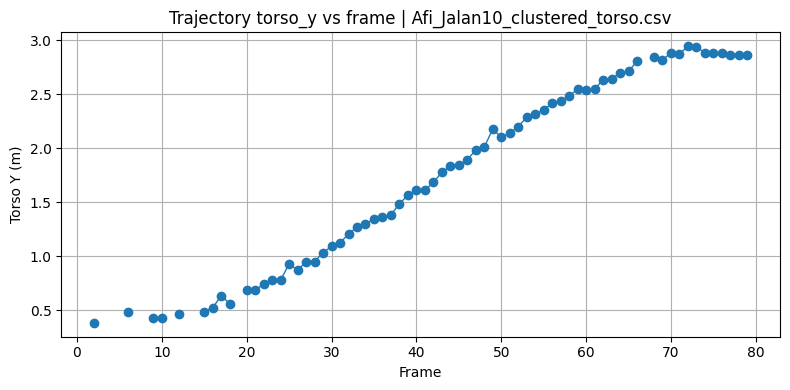

In [54]:
plt.figure(figsize=(8, 4))
plt.plot(df_torso['frame'], df_torso['torso_y'], marker='o', linewidth=1)
plt.xlabel("Frame")
plt.ylabel("Torso Y (m)")
plt.title(f"Trajectory torso_y vs frame | {os.path.basename(example_torso_csv)}")
plt.grid(True)
plt.tight_layout()
plt.show()


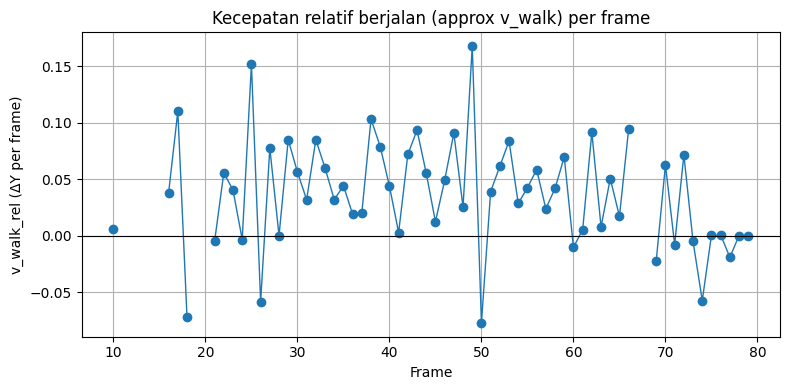

In [55]:
# Asumsi frame terurut
df_torso_sorted = df_torso.sort_values('frame').reset_index(drop=True)

# Delta posisi / delta frame (kalau tau fps, bisa dikonversi ke m/s)
df_torso_sorted['dy'] = df_torso_sorted['torso_y'].diff()
df_torso_sorted['v_walk_rel'] = df_torso_sorted['dy']  # relatif per frame

plt.figure(figsize=(8, 4))
plt.plot(df_torso_sorted['frame'], df_torso_sorted['v_walk_rel'], marker='o', linewidth=1)
plt.axhline(0, color='k', linewidth=0.8)
plt.xlabel("Frame")
plt.ylabel("v_walk_rel (ΔY per frame)")
plt.title("Kecepatan relatif berjalan (approx v_walk) per frame")
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
import os
import glob
import numpy as np
import pandas as pd

def evaluate_torso_file(path_csv):
    """
    Evaluasi kualitas torso-per-frame untuk 1 file.
    Mengembalikan dict metrik.
    """
    df = pd.read_csv(path_csv)

    # kalau belum ada kolom is_held_from_prev, anggap 0
    if 'is_held_from_prev' not in df.columns:
        df['is_held_from_prev'] = 0

    # --- 1. Coverage ---
    valid = (df['num_points_torso'] > 0) | (df['is_held_from_prev'] == 1)
    coverage = valid.mean() * 100  # persen

    # --- 2. Max Gap Length ---
    gaps = []
    current = 0
    for v in valid:
        if not v:
            current += 1
        else:
            gaps.append(current)
            current = 0
    gaps.append(current)
    max_gap = max(gaps)

    # --- 3. Hold Ratio ---
    hold_ratio = (df['is_held_from_prev'] == 1).mean() * 100

    # --- 4. Smoothness (Δx, Δy, Δz) ---
    dx_mean = df['torso_x'].diff().abs().mean()
    dy_mean = df['torso_y'].diff().abs().mean()
    dz_mean = df['torso_z'].diff().abs().mean()

    return {
        "file": os.path.basename(path_csv),
        "coverage_pct": coverage,
        "max_gap_frames": max_gap,
        "hold_ratio_pct": hold_ratio,
        "dx_mean": dx_mean,
        "dy_mean": dy_mean,
        "dz_mean": dz_mean,
        "n_frames": len(df),
    }


In [2]:
def evaluate_all_torso_files(folder_torso, pattern="*_torso.csv"):
    """
    Evaluasi semua file *_torso.csv di folder_torso.
    Mengembalikan DataFrame berisi metrik per file.
    """
    paths = sorted(glob.glob(os.path.join(folder_torso, pattern)))
    results = []

    for p in paths:
        try:
            metrics = evaluate_torso_file(p)
            # optional: ekstrak nama subjek dari nama file (sebelum '_' pertama)
            fname = os.path.basename(p)
            subject = fname.split("_")[0]  # misal 'Afi_Jalan1_torso.csv' -> 'Afi'
            metrics["subject"] = subject
            results.append(metrics)
        except Exception as e:
            print(f"Error evaluating {p}: {e}")

    if not results:
        print("Tidak ada file torso yang cocok pattern di folder ini.")
        return pd.DataFrame()

    df_metrics = pd.DataFrame(results)
    return df_metrics


In [3]:
FOLDER_TORSO = r"E:\1.Clustering_TA\output_clustering\02_torso_per_frame"

df_eval = evaluate_all_torso_files(FOLDER_TORSO)
df_eval

,file,coverage_pct,max_gap_frames,hold_ratio_pct,dx_mean,dy_mean,dz_mean,n_frames,subject
0,Afi_Jalan10_clustered_torso.csv,86.075949,3,3.797468,0.027119,0.047512,0.064152,79,Afi
1,Afi_Jalan11_clustered_torso.csv,59.756098,24,30.487805,0.014868,0.021644,0.062222,82,Afi
2,Afi_Jalan12_clustered_torso.csv,69.090909,20,12.727273,0.029417,0.040819,0.056659,110,Afi
3,Afi_Jalan13_clustered_torso.csv,84.745763,4,74.576271,0.002875,0.003762,0.018861,59,Afi
4,Afi_Jalan14_clustered_torso.csv,55.128205,11,53.846154,0.000000,0.000000,0.000000,78,Afi
...,...,...,...,...,...,...,...,...,...
211,Miftah_Jalan71_clustered_torso.csv,83.018868,31,78.867925,0.002975,0.006023,0.003630,265,Miftah
212,Miftah_Jalan72_clustered_torso.csv,82.786885,31,82.513661,0.000000,0.000000,0.000000,366,Miftah
213,Miftah_Jalan7_clustered_torso.csv,87.254902,2,9.803922,0.032753,0.032432,0.056419,102,Miftah
214,Miftah_Jalan8_clustered_torso.csv,72.277228,14,10.891089,0.049741,0.052939,0.070113,101,Miftah


In [4]:
if not df_eval.empty:
    print("\n--- Ringkasan per subjek ---")
    df_subject = df_eval.groupby("subject").agg({
        "coverage_pct": ["mean", "min"],
        "max_gap_frames": ["mean", "max"],
        "hold_ratio_pct": ["mean"],
        "dx_mean": ["mean"],
        "dy_mean": ["mean"],
        "dz_mean": ["mean"],
        "n_frames": ["sum"]
    })
    display(df_subject)



--- Ringkasan per subjek ---


coverage_pct            max_gap_frames     hold_ratio_pct   dx_mean  \
                mean        min           mean max           mean      mean   
subject                                                                       
Afi        76.260320  52.252252      14.583333  44      49.332232  0.016373   
Kinan      81.894439  58.273381      10.555556  47      52.297897  0.017740   
Miftah     81.660227  45.038168      11.722222  61      51.323612  0.019201   

          dy_mean   dz_mean n_frames  
             mean      mean      sum  
subject                               
Afi      0.014376  0.025087    10093  
Kinan    0.016470  0.032220    10096  
Miftah   0.017880  0.031544    10605